# Diffusion Model for MNIST Data

### Needed Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
# Torch functions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [5]:
# let it use cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Part 1

We will start working with the loss for conditional mean.

## 1. (a) Define a Gaussian random features for encoding time steps and fully connected layer

In [7]:
class GaussianFourierProjection(nn.Module):
# Gaussian random features for encoding time steps.
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x * self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
# A fully connected layer that reshapes outputs to feature maps.
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

- GaussianFourierProjection:

This module generates Gaussian random features for encoding time steps. It projects the time t onto a higher-dimensional space using sinusoidal functions. The scale parameter controls the spread of these features.

## 1. (b) Define the Unet model for diffusion model

In [6]:
class ScoreNet(nn.Module):
# A time-dependent score-based model with conditional mean computation.

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

        # Parameters for conditional mean computation
        self.rho0 = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.rho1 = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x, t):

        embed = self.act(self.embed(t))

        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Compute conditional mean μ(x, t; θ)
        mean = self.rho0 * (x - self.rho1 * h)

        return mean

- ScoreNet:

This class defines the main network architecture. The input x is processed through convolutional layers, with each layer progressively extracting higher-level features.

The input t is also passed through the GaussianFourierProjection module to obtain time-dependent embeddings. These time-dependent embeddings are then combined with the feature maps at each stage of the network.

The feature maps are processed through convolutional layers (conv) and combined with the corresponding time-dependent embeddings (dense).

Group normalization (gnorm) is applied after each convolutional layer followed by an activation function (swish).

The network then undergoes transpose convolution (tconv) to upsample the feature maps back to the original input size.

At each stage of transpose convolution, the corresponding time-dependent embedding is again combined with the feature maps.

Finally, the output is obtained after the last convolutional layer.

- Time Dependency:

The time parameter t affects the output through its influence on the embeddings generated by the GaussianFourierProjection module.

These embeddings are added to the feature maps at each stage of the network, effectively injecting time-dependent information into the network's computation.

This allows the model to adapt its denoising process based on the current time step, enabling dynamic behavior over time.

## 1. (c) Define a diffusion model

In [12]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device
        self.min_beta = min_beta
        self.max_beta = max_beta

        # Initialize beta, alpha, and alpha bar
        self.beta = torch.linspace(min_beta, max_beta, n_steps, dtype=torch.float32).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, axis=0)

        self.sqrt_alpha_bar = self.alpha_bar ** 0.5
        self.sqrt_one_minus_alpha_bar = (1 - self.alpha_bar) ** 0.5

    def forward_process(self, x0, t):
        # Sample x_{t-1}, x_t given x_0
        ## sample x_{t-1} conditional on x_0
        noise = torch.randn(x0.shape).to(self.device)
        s1 = self.sqrt_alpha_bar[t-1].reshape(-1,1,1,1)
        s2 = self.sqrt_one_minus_alpha_bar[t-1].reshape(-1,1,1,1)
        xt_1 = s1 * x0 + s2 * noise

        ## sample x_t conditional on x_{t-1}
        alpha_t = self.alpha[t].reshape(-1,1,1,1)
        xt = torch.sqrt(alpha_t) * xt_1 + torch.sqrt(1 - alpha_t) * torch.randn_like(xt_1).to(self.device)

        return xt_1, xt

    def predict_next(self, xt, t):
        # Compute mu(xt, t)
        mu = self.model(xt, t)
        return mu

## 1. (d) Define the loss function 

To reduce the variance of the estimate in the loss function, we can use a technique called importance sampling. Importance sampling involves sampling from a distribution that has a similar shape to the true distribution but with heavier tails, which helps to reduce the variance of the estimate. The parameter for exponential distribution is 0.03 here, tuned by myself. (I tried 1, 0.5, 0.1, 0.03, 0.01)

In [8]:
import torch.distributions as D

def loss_function_exp(diffusion, X_batch, device):
    batch_size = len(X_batch)
    n_steps = diffusion.n_steps

    # Draw random time steps for all examples in the batch using exponential distribution
    exponential_dist = D.Exponential(torch.tensor([0.03]))
    t_batch = exponential_dist.sample((batch_size, 1)).long().to(device).view(-1,1)
    t_batch = torch.clamp(t_batch, 0, n_steps-1)

    # Perform forward diffusion process to sample Xtj-1 and Xtj
    xtj_1, xtj = diffusion.forward_process(X_batch, t_batch)

    # Predict the mean for all examples
    mu_xtj_batch = diffusion.predict_next(xtj, t_batch)

    # Calculate loss for all examples
    alpha_t = diffusion.alpha[t_batch].view(batch_size, 1, 1, 1)
    loss = torch.sum((xtj_1 - mu_xtj_batch) ** 2 / (2 * (1 - alpha_t))) / batch_size

    return loss

## 1. (e) Load MNIST data

In [12]:
data = np.float64(np.load('./data/MNIST_data.npy'))
labels = np.float32(np.load('./data/MNIST_labels.npy'))
print(type(data), data.shape)

<class 'numpy.ndarray'> (70000, 784)


In [24]:
def get_mnist():
    data = np.float64(np.load('./data/MNIST_data.npy'))
    labels = np.float32(np.load('./data/MNIST_labels.npy'))
    print(data.shape)
    data = np.float32(data)/255.
    train_dat = data[0:50000].reshape((-1,1,28,28))
    train_labels = np.int32(labels[0:50000])
    val_dat = data[50000:55000].reshape((-1,1,28,28))
    val_labels = np.int32(labels[50000:55000])
    test_dat = data[55000:70000].reshape((-1,1,28,28))
    test_labels = np.int32(labels[55000:70000])

    train_dataset = TensorDataset(torch.from_numpy(train_dat), torch.from_numpy(train_labels))
    val_dataset = TensorDataset(torch.from_numpy(val_dat), torch.from_numpy(val_labels))
    test_dataset = TensorDataset(torch.from_numpy(test_dat), torch.from_numpy(test_labels))

    return train_dataset, val_dataset, test_dataset

In [25]:
train_dataset, val_dataset, test_dataset = get_mnist()

(70000, 784)


## 1. (f) Training and validation

Set parameters

In [27]:
T = 200
learning_rate = 0.01
initial_rho_lr = 0.2
num_epochs = 60
batch_size = 100
min_beta = 0.0001
max_beta = 0.1

Set data loader

In [28]:
# Set data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Initialize ScoreNet and Diffusion, set optimizer and learning rate

In [29]:
score_net = ScoreNet().to(device)
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)

In [30]:
optimizer = optim.Adam([
    {'params': list(score_net.parameters())[2:], 'lr': learning_rate},
    {'params': [score_net.rho0, score_net.rho1], 'lr': initial_rho_lr}
])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Training

In [86]:
for epoch in range(num_epochs):
    score_net.train()

    train_loss = 0.0
    for batch_idx, (X_batch, target) in enumerate(train_loader):
        X_batch = X_batch.to(device)

        loss = loss_function_exp(diffusion, X_batch, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validate the model
    score_net.eval()

    valid_loss = 0.0
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)

            loss = loss_function_exp(diffusion, X_batch, device)
            valid_loss += loss.item() * X_batch.size(0)

    valid_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}')

    scheduler.step()

Epoch 1/60, Train Loss: 43751.41807, Valid Loss: 487.42702
Epoch 2/60, Train Loss: 434.46219, Valid Loss: 407.20177
Epoch 3/60, Train Loss: 397.91358, Valid Loss: 392.70797
Epoch 4/60, Train Loss: 391.10446, Valid Loss: 389.18448
Epoch 5/60, Train Loss: 389.30843, Valid Loss: 388.91347
Epoch 6/60, Train Loss: 388.27619, Valid Loss: 387.79373
Epoch 7/60, Train Loss: 386.68903, Valid Loss: 385.61799
Epoch 8/60, Train Loss: 385.04798, Valid Loss: 384.43518
Epoch 9/60, Train Loss: 383.46145, Valid Loss: 383.02904
Epoch 10/60, Train Loss: 381.99937, Valid Loss: 381.15633
Epoch 11/60, Train Loss: 380.18083, Valid Loss: 379.45584
Epoch 12/60, Train Loss: 377.57956, Valid Loss: 376.15013
Epoch 13/60, Train Loss: 373.72428, Valid Loss: 371.88723
Epoch 14/60, Train Loss: 371.66042, Valid Loss: 370.13821
Epoch 15/60, Train Loss: 368.79160, Valid Loss: 367.06022
Epoch 16/60, Train Loss: 366.75787, Valid Loss: 366.71679
Epoch 17/60, Train Loss: 366.57598, Valid Loss: 365.49235
Epoch 18/60, Train Lo

save the model

In [87]:
torch.save(score_net.state_dict(), '/score_net_exploss003.pt')
torch.save(diffusion.state_dict(), '/diffusion_exploss003.pt')

## 1. (g) Define a function to sample image

load the model back

In [75]:
score_net = ScoreNet().to(device)
score_net.load_state_dict(torch.load('/score_net_exploss003.pt'))
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)
diffusion.load_state_dict(torch.load('/diffusion_exploss003.pt'))

<All keys matched successfully>

In [71]:
def sample_from_model(score_net, diffusion, device, sample_size=1):
    with torch.no_grad():
        x_sample = torch.randn((sample_size, 1, 28, 28), device=device)

        for t in range(diffusion.n_steps - 1, 0, -1):
            t_tensor = torch.tensor([t], dtype=torch.float32, device=device).repeat(x_sample.shape[0], 1)
            mean = diffusion.predict_next(x_sample, t)
            noise = torch.randn_like(x_sample).to(device)
            x_sample = mean + (1.0 - diffusion.alpha[t]) ** 0.5 * noise

    return x_sample

## 1. (h) Sample 1000 samples and graph 20 samples

In [147]:
sampled_images = sample_from_model(score_net, diffusion, device, sample_size=1000)

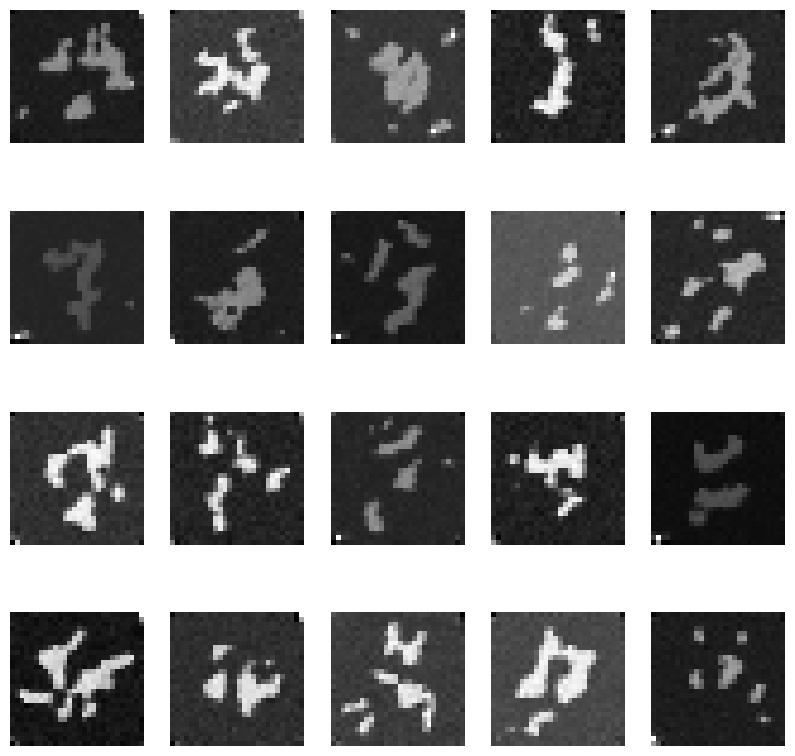

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(sampled_images.cpu().detach().numpy()[i, 0], cmap='gray')
    ax.axis('off')
plt.show()

The results are somehow the handwritten digits, but not well. 

Calculate FID score to compare with the real handwritten digits from train data. 

In [123]:
def calculate_fid_score(real_samples, generated_samples, eps=1e-4):
    real_samples = real_samples.cpu().detach().numpy()
    generated_samples = generated_samples.cpu().detach().numpy()

    mu_real = np.mean(real_samples, axis=0)
    mu_generated = np.mean(generated_samples, axis=0)

    cov_real = np.cov(real_samples[0][0], rowvar=False)
    cov_generated = np.cov(generated_samples[0][0], rowvar=False)

    # Add a small epsilon to the diagonal of covariance matrices to ensure they are positive definite
    cov_real += np.eye(cov_real.shape[0]) * eps
    cov_generated += np.eye(cov_generated.shape[0]) * eps

    mean_diff = mu_real - mu_generated
    mean_diff_squared = np.sum(mean_diff ** 2)

    cov_sqrt = np.sqrt(np.dot(cov_real, cov_generated))

    # If there are NaNs in the result, add a larger epsilon and recompute
    if np.isnan(cov_sqrt).any():
        cov_real += np.eye(cov_real.shape[0]) * 10 * eps
        cov_generated += np.eye(cov_generated.shape[0]) * 10 * eps
        cov_sqrt = np.sqrt(np.dot(cov_real, cov_generated))

    fid = mean_diff_squared + np.trace(cov_real) + np.trace(cov_generated) - 2 * np.trace(cov_sqrt)
    return fid

In [143]:
real_images = []
for batch, _ in train_loader:
    real_images.append(batch)
real_images = torch.cat(real_images)[1500:2500]

In [148]:
calculate_fid_score(real_images, sampled_images, eps=1e-5)

1.783533164671161

# Part 2. 

We will start working with the loss for error.

## 2. (a) Define the Unet model

However, this time don't need to have $\rho_1$ and $\rho_2$ in the model to tune. 

In [15]:
class ScoreNet(nn.Module):
# A time-dependent score-based model with conditional mean computation."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)

        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h

Define the loss, here the parameter of exponential distribution is 0.03, which is also tuned by myself.

In [16]:
def loss_function_epsilon(diffusion, X_batch, device):
    batch_size = len(X_batch)
    n_steps = diffusion.n_steps

    # Draw random time steps for all examples in the batch using exponential distribution
    exponential_dist = D.Exponential(torch.tensor([0.03]))
    t_batch = exponential_dist.sample((batch_size, 1)).long().to(device).view(-1,1)
    t_batch = torch.clamp(t_batch, 0, n_steps-1)

    # Draw random vector j from N(0,I)
    noisej = torch.randn(X_batch.shape, device=device)

    # Produce Xtj
    xtj = diffusion.alpha_bar[t_batch].view(-1, 1, 1, 1) * X_batch + diffusion.sqrt_one_minus_alpha_bar[t_batch].view(-1, 1, 1, 1) * noisej

    # Run through the model
    e = diffusion.predict_next(xtj, t_batch)

    # Calculate loss
    loss = torch.sum((noisej - e) ** 2) / batch_size

    return loss

## 2. (b) Training and Validation

Initialize ScoreNet and Diffusion, set optimizer and learning rate

In [17]:
score_net = ScoreNet().to(device)
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)

In [18]:
optimizer = optim.Adam([
    {'params': list(score_net.parameters()), 'lr': learning_rate},
])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Training

In [19]:
for epoch in range(num_epochs):
    score_net.train()

    train_loss = 0.0
    for batch_idx, (X_batch, target) in enumerate(train_loader):
        X_batch = X_batch.to(device)

        loss = loss_function_epsilon(diffusion, X_batch, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)


    train_loss /= len(train_loader.dataset)

    # Validate the model
    score_net.eval()

    valid_loss = 0.0
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)

            loss = loss_function_epsilon(diffusion, X_batch, device)
            valid_loss += loss.item() * X_batch.size(0)

    valid_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}')

    scheduler.step()

Epoch 1/60, Train Loss: 389.56865, Valid Loss: 218.62305
Epoch 2/60, Train Loss: 189.83811, Valid Loss: 152.70160
Epoch 3/60, Train Loss: 122.50661, Valid Loss: 92.95112
Epoch 4/60, Train Loss: 91.47715, Valid Loss: 86.92159
Epoch 5/60, Train Loss: 79.78399, Valid Loss: 76.83028
Epoch 6/60, Train Loss: 73.26122, Valid Loss: 69.01616
Epoch 7/60, Train Loss: 71.03543, Valid Loss: 65.53199
Epoch 8/60, Train Loss: 71.07828, Valid Loss: 67.56586
Epoch 9/60, Train Loss: 64.59223, Valid Loss: 60.70384
Epoch 10/60, Train Loss: 61.77374, Valid Loss: 59.66210
Epoch 11/60, Train Loss: 59.33579, Valid Loss: 56.92474
Epoch 12/60, Train Loss: 57.39046, Valid Loss: 57.21599
Epoch 13/60, Train Loss: 55.55547, Valid Loss: 54.65063
Epoch 14/60, Train Loss: 53.74620, Valid Loss: 54.15612
Epoch 15/60, Train Loss: 138.63217, Valid Loss: 266.14948
Epoch 16/60, Train Loss: 229.70191, Valid Loss: 183.83542
Epoch 17/60, Train Loss: 153.30336, Valid Loss: 114.50527
Epoch 18/60, Train Loss: 108.36128, Valid Loss

## 2. (c) Sample images and compare with real images

In [20]:
def sample_from_model_2(score_net, diffusion, device, sample_size=1):
    with torch.no_grad():
        x_sample = torch.randn((sample_size, 1, 28, 28), device=device)

        for t in range(diffusion.n_steps - 1, 0, -1):
            noise = diffusion.predict_next(x_sample, t)
            mean = (x_sample - (1-diffusion.alpha[t])*noise / (diffusion.sqrt_one_minus_alpha_bar[t])) / torch.sqrt(diffusion.alpha[t])
            z = torch.randn((sample_size, 1, 28, 28), device=device)
            x_sample = mean + (1.0 - diffusion.alpha[t]) ** 0.5 * z

    return x_sample

Sample 1000 samples and graph 20 samples

In [21]:
sampled_images_2 = sample_from_model_2(score_net, diffusion, device, sample_size=1000)

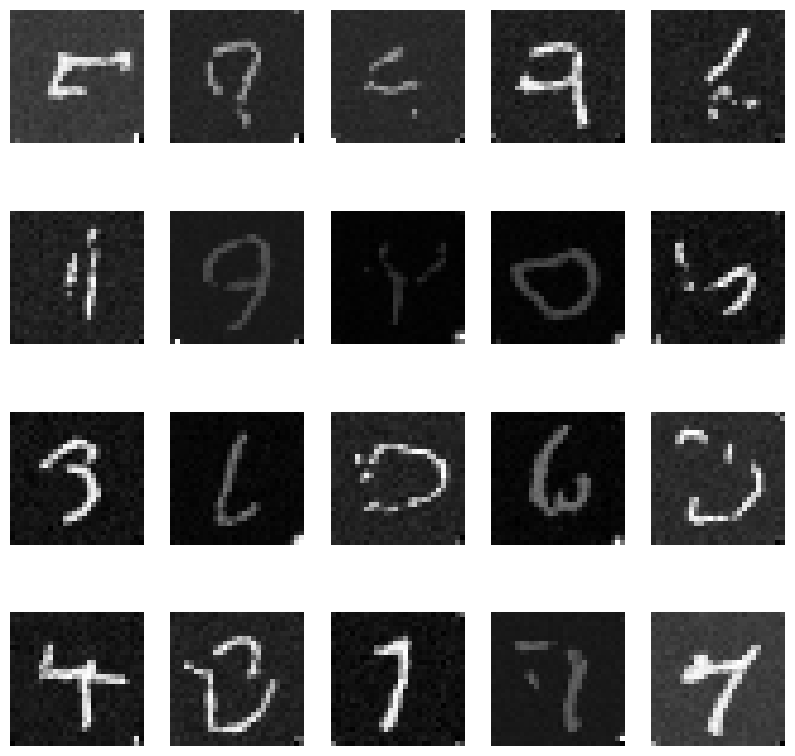

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(sampled_images_2.cpu().detach().numpy()[i, 0], cmap='gray')
    ax.axis('off')
plt.show()

This time is more like handwritten digits. 

Calculate FID score

In [145]:
calculate_fid_score(real_images, sampled_images_2, eps=1e-5)

9.564604305921785

save the model

In [109]:
torch.save(score_net.state_dict(), '/score_net_2_exploss003.pt')
torch.save(diffusion.state_dict(), '/diffusion_2_exploss003.pt')

load the model back

In [ ]:
score_net = ScoreNet().to(device)
score_net.load_state_dict(torch.load('/score_net_2_exploss003.pt'))
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)
diffusion.load_state_dict(torch.load('/diffusion_2_exploss003.pt'))

<All keys matched successfully>

## 3. Comparisons

In Part 1, the model is used to directly model the conditional mean
$\mu(x_t,t;\theta)$ given the input and time step. This means the model learns to predict the mean of the next state given the current state and the time step.

In Part 2, the model is used to directly model the error term $e(x_t,t;\theta)$ given the input and time step. This means the model learns to predict the error term that is added to the current state to generate the next state according to the diffusion process.

Observable differences between the two versions include:

- Model Output: In Part 1, the model outputs the conditional mean, while in Part 2, the model outputs the error term.

- Sampling Process: In Part 1, the sampling process involves generating samples based on the predicted mean and adding noise according to the diffusion process. In Part 2, the sampling process involves generating samples based on the predicted error term and adding noise according to the diffusion process.

- Loss Function: The loss function used for training differs between the two versions. In Part 1, the loss function is based on the squared difference between the predicted mean and the ground truth next state. In Part 2, the loss function is based on the squared difference between the predicted error term and the actual error term generated during the diffusion process.

- Sample Images: From the trained models in two problems, we can observe somehow handwritten digits, but we got more clear image in error model.